<a href="https://colab.research.google.com/github/ElmerAlanoca/BraTS2020/blob/main/BraTS2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os

# Define the credentials to access Kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

# You can create your own API token and username on the Kaggle platform
# You must change the following data for your account
api_token = {"username":"elmeralanoca","key":"4689116579b1173f6bf84b8d145a5f14"}

import json

# Create a file with the credentials so that Kaggle can easily access it.
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [4]:
%cd /content

# Check if the dataset has already been downloaded
if not os.path.exists('./brats20-dataset-training-validation'):
  os.makedirs('brats20-dataset-training-validation')
else: 
  !rm -rf brats20-dataset-training-validation

/content


In [3]:
# Download a dataset from Kaggle
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

100% 4.14G/4.16G [00:35<00:00, 144MB/s]
100% 4.16G/4.16G [00:35<00:00, 124MB/s]


In [5]:
# Uncompress dataset
!unzip -qn '/content/brats20-dataset-training-validation.zip' -d /content/brats20-dataset-training-validation > /dev/null  

In [6]:
# We delete the .zip
!rm /content/brats20-dataset-training-validation.zip

In [17]:
import nibabel as nib
import glob
import tensorflow as tf 
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

In [11]:
TRAIN_DATASET_PATH = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PAT = '/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

In [12]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_flair.nii').get_fdata()
print(test_image_flair.max())

1854.603271484375


In [13]:
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_flair=scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [16]:
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1=scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce=scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2=scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

In [19]:
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/W39_1998.09.19_Segm.nii').get_fdata()
test_mask=test_mask.astype(np.uint8)

In [20]:
print(np.unique(test_mask))  #0, 1, 2, 4 (Need to reencode to 0, 1, 2, 3)
test_mask[test_mask==4] = 3  #Reassign mask values 4 to 3
print(np.unique(test_mask)) 

[0 1 2 4]
[0 1 2 3]


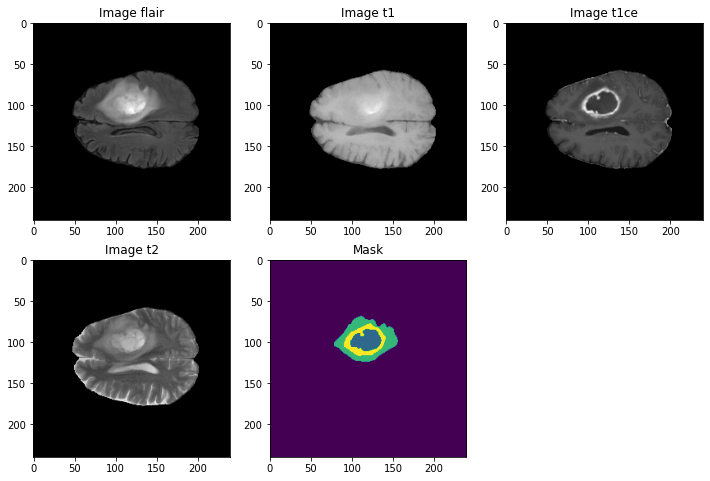

In [22]:
import random
n_slice=random.randint(0, test_mask.shape[2])

plt.figure(figsize=(12, 8))

plt.subplot(231)
plt.imshow(test_image_flair[:,:,n_slice], cmap='gray')
plt.title('Image flair')
plt.subplot(232)
plt.imshow(test_image_t1[:,:,n_slice], cmap='gray')
plt.title('Image t1')
plt.subplot(233)
plt.imshow(test_image_t1ce[:,:,n_slice], cmap='gray')
plt.title('Image t1ce')
plt.subplot(234)
plt.imshow(test_image_t2[:,:,n_slice], cmap='gray')
plt.title('Image t2')
plt.subplot(235)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [23]:
#Flair, T1CE, annd T2 have the most information
#Combine t1ce, t2, and flair into single multichannel image

combined_x = np.stack([test_image_flair, test_image_t1ce, test_image_t2], axis=3)

In [29]:
#Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
#cropping x, y, and z
#combined_x=combined_x[24:216, 24:216, 13:141]

combined_x=combined_x[56:184, 56:184, 13:141] #Crop to 128x128x128x4

#Do the same for mask
test_mask = test_mask[56:184, 56:184, 13:141]

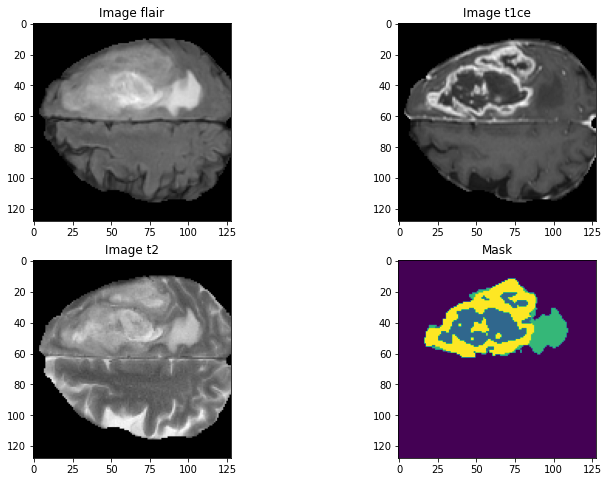

In [30]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(combined_x[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(combined_x[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(combined_x[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [32]:
imsave('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/combined355.tif', combined_x)
np.save('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/combined355.npy', combined_x)

In [35]:
#Verify image is being read properly
#my_img=imread('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/combined355.tif')
my_img=np.load('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/combined355.npy')

In [37]:
test_mask = to_categorical(test_mask, num_classes=4)

In [38]:
#Now let us apply the same as above to all the images...
#Merge channels, crop, patchify, save
#GET DATA READY =  GENERATORS OR OTHERWISE

#Keras datagenerator does ntot support 3d

# # # images lists harley
#t1_list = sorted(glob.glob('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes

In [43]:
!mkdir /content/brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_3channels

In [44]:
!mkdir /content/brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_3channels/images
!mkdir /content/brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_3channels/masks

In [45]:
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        print("Save Me")
        temp_mask= to_categorical(temp_mask, num_classes=4)
        np.save('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
        np.save('/content/brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
        
    else:
        print("I am useless")  


Now preparing image and masks number:  0
Save Me
Now preparing image and masks number:  1
Save Me
Now preparing image and masks number:  2
Save Me
Now preparing image and masks number:  3
Save Me
Now preparing image and masks number:  4
I am useless
Now preparing image and masks number:  5
Save Me
Now preparing image and masks number:  6
Save Me
Now preparing image and masks number:  7
Save Me
Now preparing image and masks number:  8
Save Me
Now preparing image and masks number:  9
Save Me
Now preparing image and masks number:  10
Save Me
Now preparing image and masks number:  11
Save Me
Now preparing image and masks number:  12
Save Me
Now preparing image and masks number:  13
Save Me
Now preparing image and masks number:  14
Save Me
Now preparing image and masks number:  15
Save Me
Now preparing image and masks number:  16
Save Me
Now preparing image and masks number:  17
Save Me
Now preparing image and masks number:  18
Save Me
Now preparing image and masks number:  19
Save Me
Now p

IndexError: ignored

In [ ]:
#Repeat the same from above for validation data folder OR
#Split training data into train and validation

In [47]:
#Code for splitting folder into train, test, and val.
#Once the new folders are created rename them and arrange in the format below to be used
#for semantic segmentation using data generators.
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import splitfolders  # or import split_folders

input_folder = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_3channels'
output_folder = '/content/brats20-dataset-training-validation/BraTS2020_TrainingData/input_data_128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

Copying files: 51 files [00:28,  1.57 files/s]

OSError: ignored